# Würzburg Weather Time Series Forecasting Analysis & Methods Comparasion
This section introduces the project and its goals.

## Introduction
In this notebook i will walk through time series forecasting by preprocessing the data, splitting into training and testing parts, than introducing the models, training each of them separately with the training dataset, evaluating the performance of models with  The data we will be using is hourly energy consumptio

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

c:\Python311\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Python311\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Python311\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Data Exploration

In this section, we will explore the weather dataset for the city of Würzburg, which spans from January 1, 1979, to June 18, 2021. The dataset contains 19,179 rows and includes daily weather information over a period of more than four decades. 

### Dataset Description

The dataset consists of the following columns:

- **date**: The date of the weather observation.
- **temp_max**: The maximum temperature recorded on the given date.
- **temp_min**: The minimum temperature recorded on the given date.
- **temp_avg**: The average temperature on the given date.
- **rain**: The amount of rainfall (in mm) recorded on the given date.
- **snow**: The amount of snowfall (in mm) recorded on the given date.
- **weather_desc**: A textual description of the weather on the given date.

### Objective

The objective of this analysis is to perform time series forecasting using different models on this weather data. By analyzing and modeling the data, we aim to predict future weather patterns, which can be valuable for various applications such as agriculture, urban planning, and personal planning.

### Initial Data Inspection

To begin our exploration, we will:
- Load the dataset.
- Inspect the first few rows of the data to understand its structure.
- Check for any missing values and handle them appropriately.
- Generate summary statistics to get an overview of the dataset.
- Visualize the data to identify any trends, seasonality, and outliers.

This initial exploration will help us gain insights into the dataset and prepare it for further analysis and modeling.


In [3]:
# Read the datasetb
weather_würzburg_df = pd.read_excel('C:/Users/AliAlpOezer/Desktop/Time_Series_Forecasting_Papers_and_relevant_files/historische-wetterdaten-kompakt-1979-2021.xlsx', index_col=[0], parse_dates=[0])

In [4]:
# Inspect the first few rows
print(weather_würzburg_df.head())

            temp_max  temp_min  temp_avg  rain  snow  \
date                                                   
1979-01-01     -8.23    -17.83    -14.54   0.0  0.10   
1979-01-02     -9.08    -14.35    -11.86   0.0  0.35   
1979-01-03     -6.65    -13.16     -9.72   0.0  0.00   
1979-01-04     -9.84    -17.65    -13.18   0.0  0.00   
1979-01-05    -12.06    -18.39    -15.56   0.0  0.00   

                                                 weather_desc  
date                                                           
1979-01-01           light snow,snow,broken clouds,few clouds  
1979-01-02  light snow,overcast clouds,mist,haze,broken cl...  
1979-01-03  broken clouds,mist,overcast clouds,scattered c...  
1979-01-04                 sky is clear,mist,scattered clouds  
1979-01-05                             mist,broken clouds,fog  


In [5]:
# get a bit more info about the dataset
print(weather_würzburg_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19178 entries, 1979-01-01 to 2021-06-18
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temp_max      19178 non-null  float64
 1   temp_min      19178 non-null  float64
 2   temp_avg      15510 non-null  float64
 3   rain          15510 non-null  float64
 4   snow          15510 non-null  float64
 5   weather_desc  15510 non-null  object 
dtypes: float64(5), object(1)
memory usage: 1.0+ MB
None


In [6]:
# Check for missing values
missing_values = weather_würzburg_df.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 temp_max           0
temp_min           0
temp_avg        3668
rain            3668
snow            3668
weather_desc    3668
dtype: int64


In [7]:
# Copy the original df and remove rows with any missing values
weather_würzburg_df_copy = weather_würzburg_df.copy()
weather_wue_df = weather_würzburg_df_copy.dropna(inplace=False)
weather_wue_df

,temp_max,temp_min,temp_avg,rain,snow,weather_desc
date,,,,,,
1979-01-01,-8.23,-17.83,-14.54,0.0,0.10,"light snow,snow,broken clouds,few clouds"
1979-01-02,-9.08,-14.35,-11.86,0.0,0.35,"light snow,overcast clouds,mist,haze,broken cl..."
1979-01-03,-6.65,-13.16,-9.72,0.0,0.00,"broken clouds,mist,overcast clouds,scattered c..."
1979-01-04,-9.84,-17.65,-13.18,0.0,0.00,"sky is clear,mist,scattered clouds"
1979-01-05,-12.06,-18.39,-15.56,0.0,0.00,"mist,broken clouds,fog"
...,...,...,...,...,...,...
2021-06-14,24.68,9.35,17.60,0.0,0.00,"broken clouds,sky is clear,few clouds"
2021-06-15,27.27,12.39,20.59,0.0,0.00,"few clouds,scattered clouds,sky is clear,broke..."
2021-06-16,28.41,16.14,22.37,0.0,0.00,"scattered clouds,broken clouds,sky is clear,fe..."


In [8]:
# Generate summary statistics
summary_statistics = weather_wue_df.describe()
print("Summary Statistics:\n", summary_statistics)

Summary Statistics:
            temp_max      temp_min      temp_avg          rain         snow
count  15510.000000  15510.000000  15510.000000  15510.000000  15510.00000
mean      13.260656      5.458574      9.330419      1.408072      0.09154
std        8.880384      6.671016      7.605794      2.996766      0.61587
min      -13.520000    -20.500000    -17.240000      0.000000      0.00000
25%        6.300000      0.650000      3.500000      0.000000      0.00000
50%       13.235000      5.660000      9.500000      0.000000      0.00000
75%       20.170000     10.760000     15.300000      1.570000      0.00000
max       36.930000     21.440000     29.270000     46.230000     17.39000


### Visualize the Data to Identify Trends, Seasonality, and Outliers


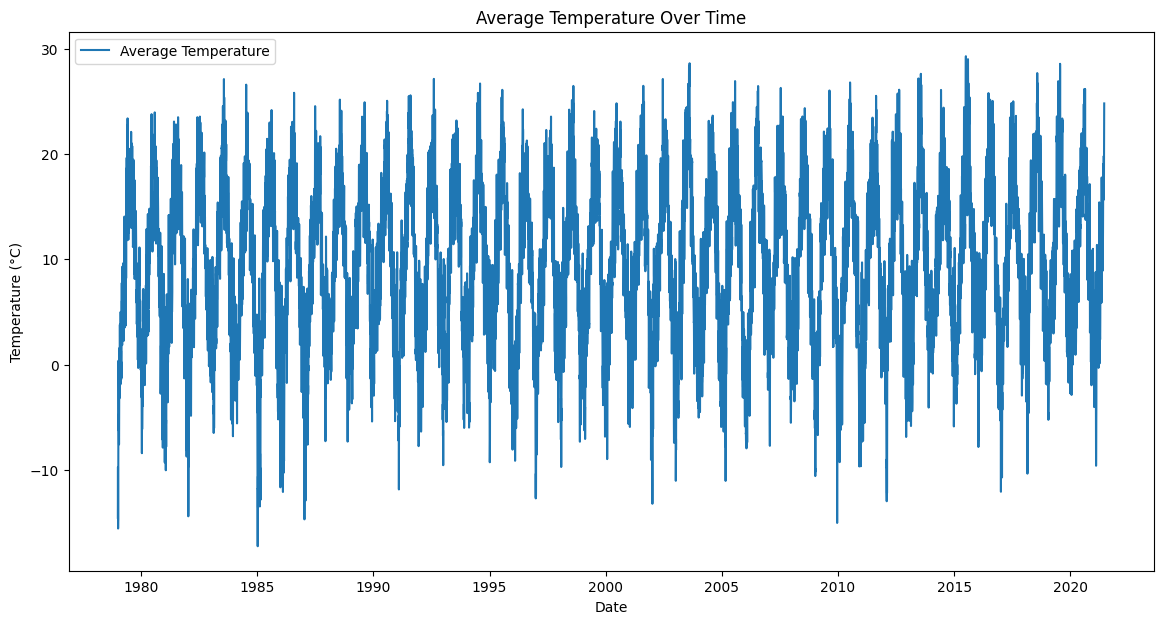

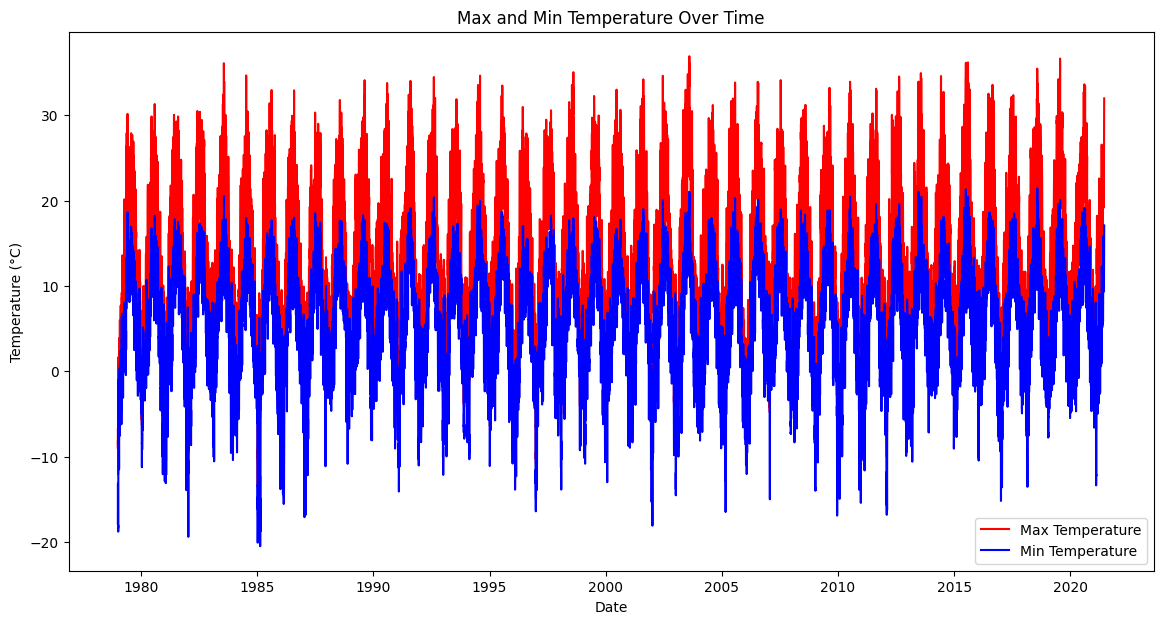

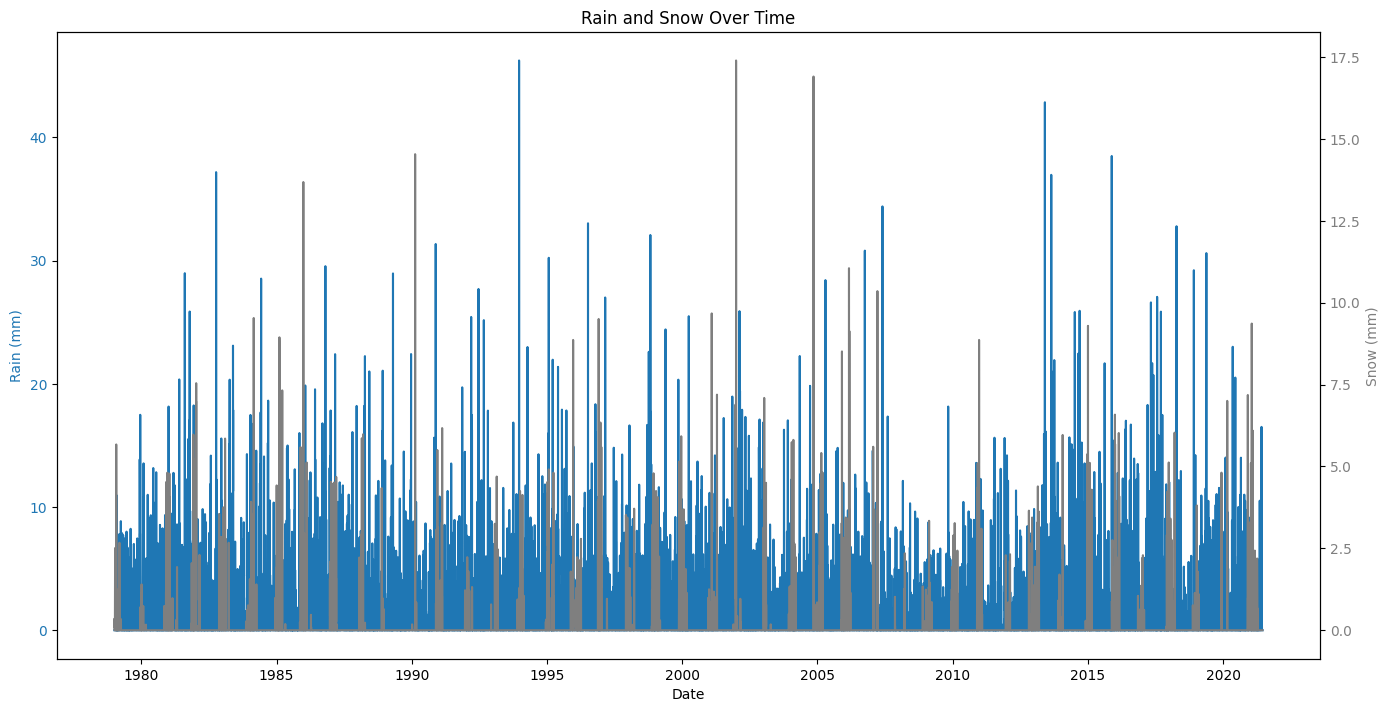

In [9]:
# Plotting the time series for average temperature
plt.figure(figsize=(14, 7))
plt.plot(weather_wue_df.index, weather_wue_df['temp_avg'], label='Average Temperature')
plt.title('Average Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

# Plotting the time series for maximum and minimum temperature
plt.figure(figsize=(14, 7))
plt.plot(weather_wue_df.index, weather_wue_df['temp_max'], label='Max Temperature', color='red')
plt.plot(weather_wue_df.index, weather_wue_df['temp_min'], label='Min Temperature', color='blue')
plt.title('Max and Min Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

# Plotting the time series for rain and snow
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Date')
ax1.set_ylabel('Rain (mm)', color='tab:blue')
ax1.plot(weather_wue_df.index, weather_wue_df['rain'], label='Rain', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Snow (mm)', color='tab:gray')
ax2.plot(weather_wue_df.index, weather_wue_df['snow'], label='Snow', color='tab:gray')
ax2.tick_params(axis='y', labelcolor='tab:gray')

fig.tight_layout()
plt.title('Rain and Snow Over Time')
plt.show()

### Splitting the Dataset
To prepare for time series forecasting, we split our dataset into training and testing sets. The training set will be used to train our models, while the testing set will be used to evaluate the performance of these models. We have chosen January 1, 2013, as the cut-off date for this split. 
The dataset is divided as follows:
- **Training Set**: Data from January 1, 1979, to December 31, 2012.
- **Testing Set**: Data from January 1, 2013, onwards.

This split allows us to train our models on a substantial portion of the historical data and test their performance on more recent data. Below is the code that performs the split and verifies the number of rows in each set:


In [10]:
# Define the cutoff date for splitting the dataset
cutoff_date = '2013-01-01'

# Ensure 'temp_avg' is a numerical column and handle missing values
weather_wue_df['temp_avg'] = pd.to_numeric(weather_wue_df['temp_avg'], errors='coerce')

# Split the dataset into training and testing sets
train_df = weather_wue_df[weather_wue_df.index < cutoff_date]
test_df = weather_wue_df[weather_wue_df.index >= cutoff_date]

print("Training set summary:")
print(train_df.head())
weather_wue_df

Training set summary:
            temp_max  temp_min  temp_avg  rain  snow  \
date                                                   
1979-01-01     -8.23    -17.83    -14.54   0.0  0.10   
1979-01-02     -9.08    -14.35    -11.86   0.0  0.35   
1979-01-03     -6.65    -13.16     -9.72   0.0  0.00   
1979-01-04     -9.84    -17.65    -13.18   0.0  0.00   
1979-01-05    -12.06    -18.39    -15.56   0.0  0.00   

                                                 weather_desc  
date                                                           
1979-01-01           light snow,snow,broken clouds,few clouds  
1979-01-02  light snow,overcast clouds,mist,haze,broken cl...  
1979-01-03  broken clouds,mist,overcast clouds,scattered c...  
1979-01-04                 sky is clear,mist,scattered clouds  
1979-01-05                             mist,broken clouds,fog  


C:\Users\AliAlpOezer\AppData\Local\Temp\ipykernel_22940\1323543453.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_wue_df['temp_avg'] = pd.to_numeric(weather_wue_df['temp_avg'], errors='coerce')


,temp_max,temp_min,temp_avg,rain,snow,weather_desc
date,,,,,,
1979-01-01,-8.23,-17.83,-14.54,0.0,0.10,"light snow,snow,broken clouds,few clouds"
1979-01-02,-9.08,-14.35,-11.86,0.0,0.35,"light snow,overcast clouds,mist,haze,broken cl..."
1979-01-03,-6.65,-13.16,-9.72,0.0,0.00,"broken clouds,mist,overcast clouds,scattered c..."
1979-01-04,-9.84,-17.65,-13.18,0.0,0.00,"sky is clear,mist,scattered clouds"
1979-01-05,-12.06,-18.39,-15.56,0.0,0.00,"mist,broken clouds,fog"
...,...,...,...,...,...,...
2021-06-14,24.68,9.35,17.60,0.0,0.00,"broken clouds,sky is clear,few clouds"
2021-06-15,27.27,12.39,20.59,0.0,0.00,"few clouds,scattered clouds,sky is clear,broke..."
2021-06-16,28.41,16.14,22.37,0.0,0.00,"scattered clouds,broken clouds,sky is clear,fe..."


In [11]:
print("\nTesting set summary:")
print(test_df.head())


Testing set summary:
            temp_max  temp_min  temp_avg  rain  snow  \
date                                                   
2013-01-01      6.93      2.21      4.99  0.00   0.0   
2013-01-02      3.92      0.64      2.09  0.00   0.0   
2013-01-03      5.19      0.80      3.34  1.12   0.0   
2013-01-04      7.50      5.38      6.62  0.61   0.0   
2013-01-05      7.40      5.54      6.23  9.84   0.0   

                                                 weather_desc  
date                                                           
2013-01-01  sky is clear,scattered clouds,overcast clouds,...  
2013-01-02  overcast clouds,scattered clouds,sky is clear,...  
2013-01-03  broken clouds,scattered clouds,few clouds,over...  
2013-01-04  overcast clouds,light intensity drizzle rain,f...  
2013-01-05  overcast clouds,light intensity drizzle rain,m...  


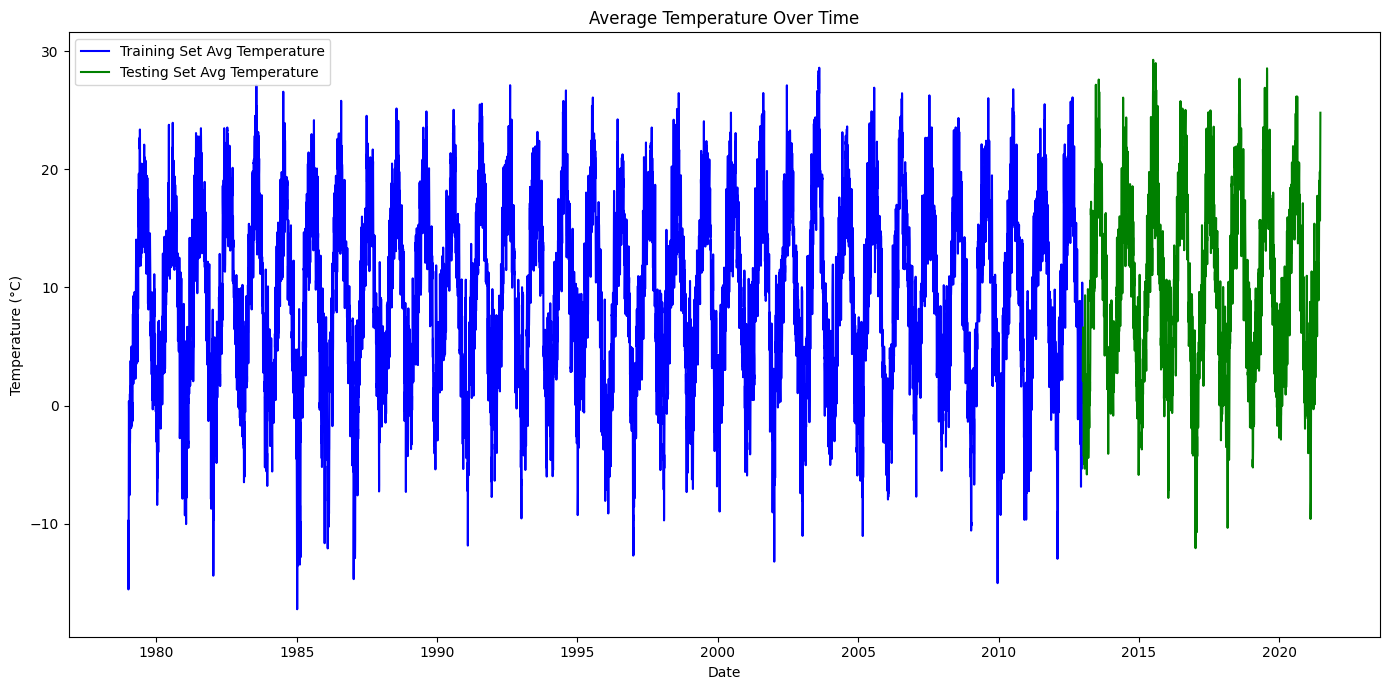

In [12]:
# Plotting the average temperature for training and testing sets

plt.figure(figsize=(14, 7))

# Plotting average temperature for the training set
plt.plot(train_df.index, train_df['temp_avg'], label='Training Set Avg Temperature', color='blue')

# Plotting average temperature for the testing set
plt.plot(test_df.index, test_df['temp_avg'], label='Testing Set Avg Temperature', color='green')

# Adding title and labels
plt.title('Average Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.tight_layout()
plt.show()

### Making the Datasets applicable for GluonTS Library


In [13]:

# Step 1: Import necessary  libraries from GluonTS
import gluonts
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import Evaluator
from gluonts.model.forecast import SampleForecast
from gluonts.dataset.util import to_pandas

# Convert to time series format expected by GluonTS
weather_wue_df_monthly = weather_wue_df['temp_avg'].resample('M').mean()
train_series_monthly = train_df['temp_avg'].resample('M').mean()
test_series_monthly = test_df['temp_avg'].resample('M').mean()


# Create ListDataset for training and testing for GluonTS
train_data = ListDataset([{"start": train_series_monthly.index[0], "target": train_series_monthly.values}], freq="M")
test_data = ListDataset([{"start": test_series_monthly.index[0], "target": test_series_monthly.values}], freq="M")
whole_data = ListDataset([{"start": weather_wue_df_monthly.index[0], "target": weather_wue_df_monthly.values}], freq="M")


test_series_monthly 

c:\Python311\Lib\site-packages\gluonts\json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


date
2013-01-31     0.319032
2013-02-28    -1.131429
2013-03-31     1.390323
2013-04-30     8.938333
2013-05-31    11.599677
                ...    
2021-02-28     2.107857
2021-03-31     5.103871
2021-04-30     6.505333
2021-05-31    10.581613
2021-06-30    19.047778
Freq: M, Name: temp_avg, Length: 102, dtype: float64

## Time Series Prediction using SARIMAX


### Hyper Parameter Optimization With Obtaning lowest AIC values of possible Models

In [14]:
import time

In [15]:
%%time
import pmdarima as pm

sarima_model = pm.auto_arima(
    train_series_monthly,
    seasonal=True,
    m=12,
    start_p=1, start_d=1, start_q=1,
    max_p=5, max_d=2, max_q=5,
    start_P=1, start_D=0, start_Q=1,
    max_P=5, max_D=2, max_Q=5,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=1740.004, Time=1.99 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2728.622, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2250.680, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3144.836, Time=0.05 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=2149.602, Time=0.34 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=1935.933, Time=0.66 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=1744.334, Time=3.22 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=3.22 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=2230.907, Time=0.14 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=2079.591, Time=1.01 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=1843.254, Time=2.87 sec
 ARIMA(1,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=5.02 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.49 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : 

### Training the best fitting SARIMAX Model with training data

                                        SARIMAX Results                                        
Dep. Variable:                                temp_avg   No. Observations:                  408
Model:             SARIMAX(3, 1, 3)x(2, 1, [1, 2], 12)   Log Likelihood                -785.571
Date:                                 Thu, 27 Jun 2024   AIC                           1597.141
Time:                                         15:19:12   BIC                           1647.911
Sample:                                     01-31-1979   HQIC                          1617.314
                                          - 12-31-2012                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0019      0.009      0.199      0.842      -0.016       0

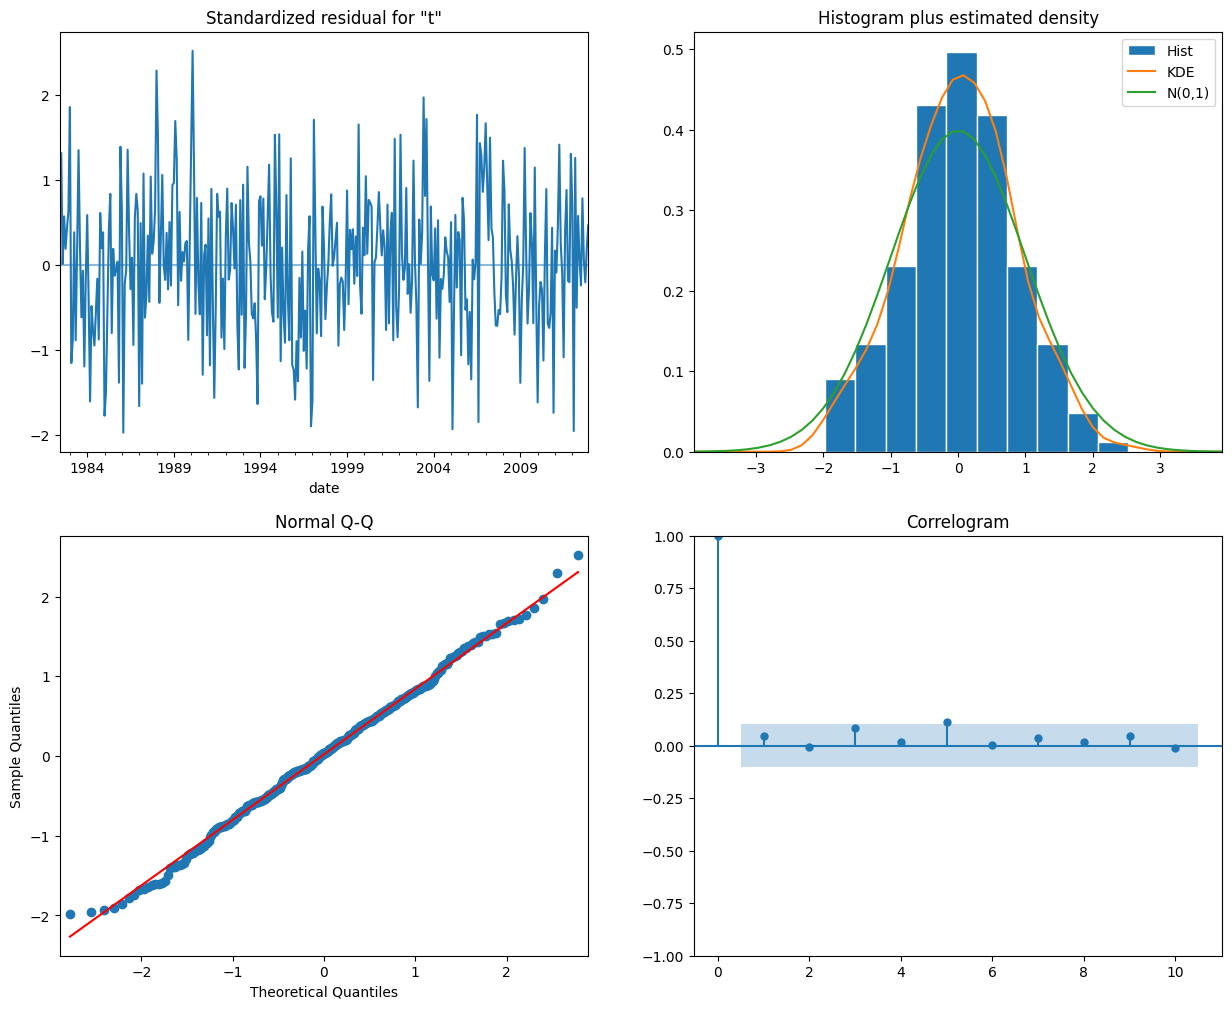

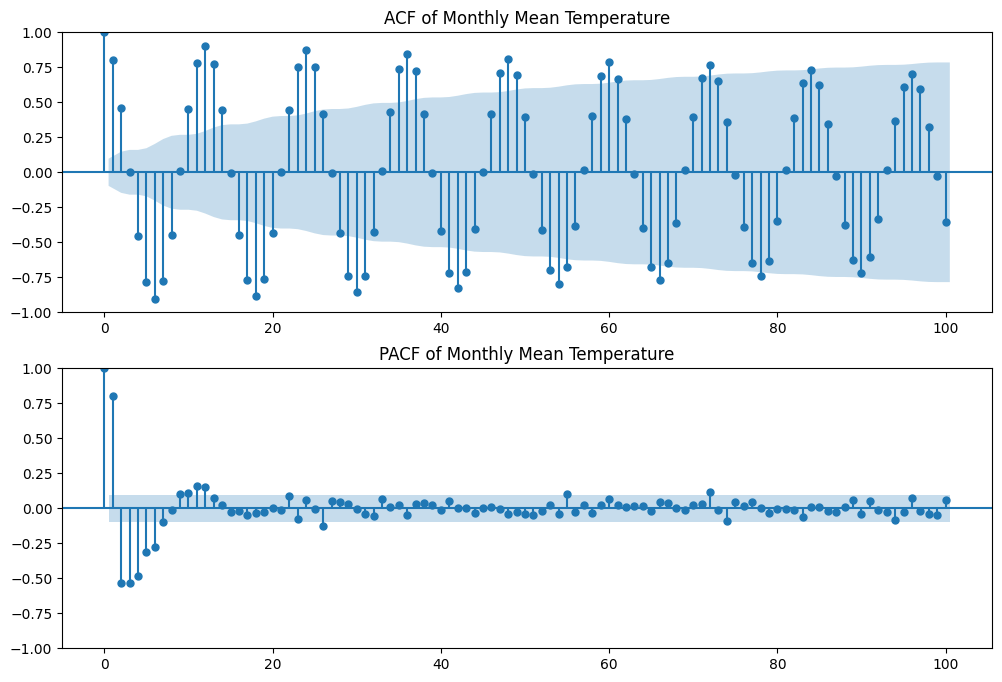

CPU times: total: 13.8 s
Wall time: 21.5 s


In [16]:
%%time

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Configure and Train the SARIMAX model (p, d, q, seasonal_order)
sarimax_model = SARIMAX(train_series_monthly, order=(3, 1, 3), seasonal_order=(2, 1, 2, 12), enforce_stationarity=False,
                        enforce_invertibility=False, trend='ct')
sarimax_result = sarimax_model.fit()

# Print model summary
print(sarimax_result.summary())

# Plot diagnostics
sarimax_result.plot_diagnostics(figsize=(15, 12))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(train_series_monthly, lags=100, ax=ax1)
ax1.set_title('ACF of Monthly Mean Temperature')

plot_pacf(train_series_monthly, lags=100, ax=ax2)
ax2.set_title('PACF of Monthly Mean Temperature')

plt.savefig('acf_pacf_plots_monthly_mean_temperature.png')

plt.show()

### Appyling The Model & Results And Comparasion With The Monthly Average Test Data 

Mean Squared Error (MSE): 5.313242408371153


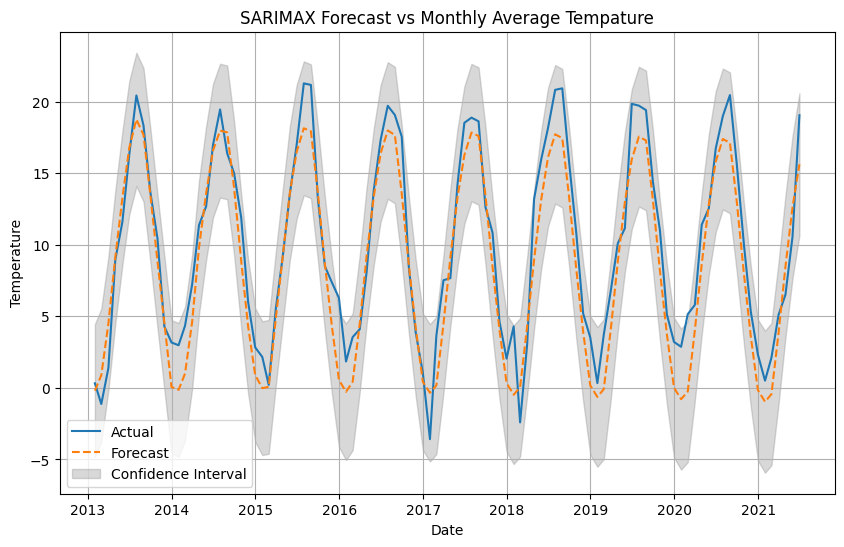

CPU times: total: 328 ms
Wall time: 1.12 s


In [17]:
%%time

# Generate forecasts and confidence intervals
forecast_results_sarima= sarimax_result.get_forecast(steps=len(test_series_monthly))
forecast_mean_sarima= forecast_results_sarima.predicted_mean
forecast_conf_int_sarima= forecast_results_sarima.conf_int(alpha=0.05)  # 95% confidence interval

# Evaluate the forecasts
from sklearn.metrics import mean_squared_error

# Compute Mean Squared Error (MSE)
mse_sarima= mean_squared_error(test_series_monthly, forecast_mean_sarima)
print("Mean Squared Error (MSE):", mse_sarima)

# Optionally, plot the forecasts against the actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(test_series_monthly.index, test_series_monthly.values, label="Actual")
plt.plot(test_series_monthly.index, forecast_mean_sarima, label="Forecast", linestyle="--")
plt.fill_between(forecast_mean_sarima.index, 
                 forecast_conf_int_sarima.iloc[:, 0], 
                 forecast_conf_int_sarima.iloc[:, 1], 
                 label="Confidence Interval", color='gray', alpha=0.3)
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("SARIMAX Forecast vs Monthly Average Tempature")
plt.legend()
plt.grid(True)
plt.show()




### Comparasion With The Daily Data

Mean Squared Error (MSE): 15.921060646700505


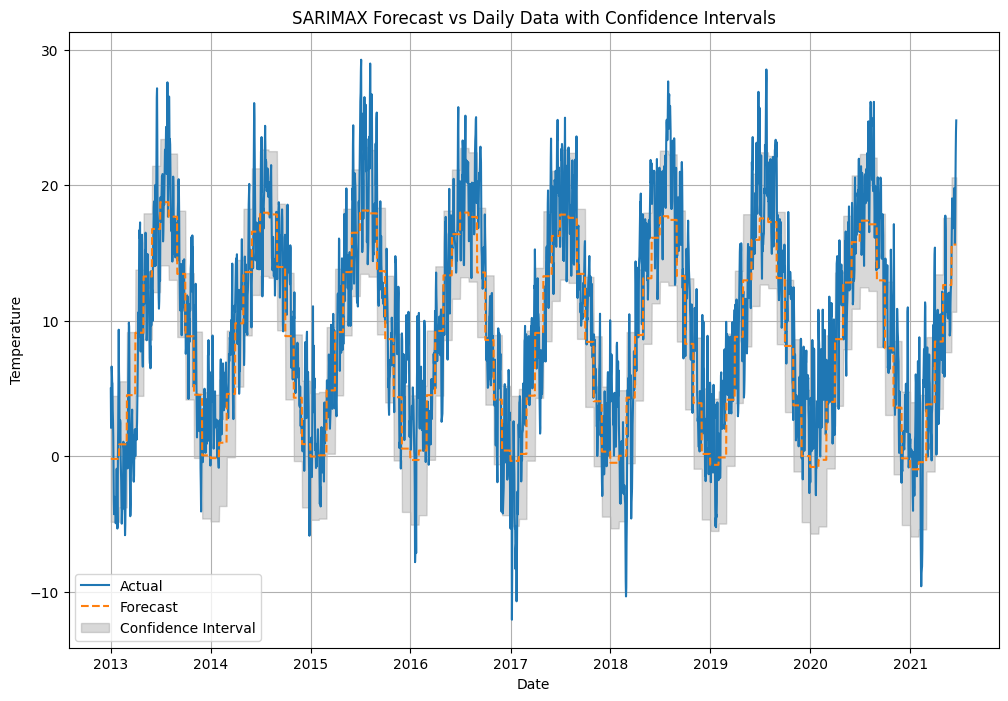

CPU times: total: 641 ms
Wall time: 1.41 s


In [18]:
%%time
# Disaggregate the monthly forecast to daily data
forecast_daily_sarima = []
conf_int_low_daily_sarima = []
conf_int_high_daily_sarima = []

for month, mean, conf in zip(test_series_monthly.index, forecast_mean_sarima.values, forecast_conf_int_sarima.values):
    days_in_month = month.days_in_month
    daily_forecast = np.full(days_in_month, mean)
    daily_conf_low = np.full(days_in_month, conf[0])
    daily_conf_high = np.full(days_in_month, conf[1])
    
    forecast_daily_sarima.append(pd.Series(daily_forecast, index=pd.date_range(month, periods=days_in_month)))
    conf_int_low_daily_sarima.append(pd.Series(daily_conf_low, index=pd.date_range(month, periods=days_in_month)))
    conf_int_high_daily_sarima.append(pd.Series(daily_conf_high, index=pd.date_range(month, periods=days_in_month)))

forecast_daily_sarima = pd.concat(forecast_daily_sarima)
conf_int_low_daily_sarima = pd.concat(conf_int_low_daily_sarima)
conf_int_high_daily_sarima = pd.concat(conf_int_high_daily_sarima)

# Adjust the forecast_daily start date to match test_df's start date
forecast_daily_sarima.index = pd.date_range(start=test_df.index[0], periods=len(forecast_daily_sarima), freq='D')
conf_int_low_daily_sarima.index = pd.date_range(start=test_df.index[0], periods=len(conf_int_low_daily_sarima), freq='D')
conf_int_high_daily_sarima.index = pd.date_range(start=test_df.index[0], periods=len(conf_int_high_daily_sarima), freq='D')

# Ensure the forecast_daily and test_df have the same date range
start_date = test_df.index[0]
end_date = test_df.index[-1]
forecast_daily_sarima = forecast_daily_sarima.loc[start_date:end_date]
conf_int_low_daily_sarima = conf_int_low_daily_sarima.loc[start_date:end_date]
conf_int_high_daily_sarima = conf_int_high_daily_sarima.loc[start_date:end_date]

# Reindex test_df to ensure it covers the same date range as forecast_daily
test_daily_sarima = test_df['temp_avg'].reindex(pd.date_range(start_date, end_date, freq='D'))

# Compute Mean Squared Error (MSE) between actual and forecasted daily data
mse_sarima = mean_squared_error(test_daily_sarima, forecast_daily_sarima)
print("Mean Squared Error (MSE):", mse_sarima)

# Plot the forecasts against the actual values along with confidence intervals
plt.figure(figsize=(12, 8))
plt.plot(test_daily_sarima.index, test_daily_sarima.values, label="Actual")
plt.plot(forecast_daily_sarima.index, forecast_daily_sarima.values, label="Forecast", linestyle="--")
plt.fill_between(forecast_daily_sarima.index, conf_int_low_daily_sarima.values, conf_int_high_daily_sarima.values,label="Confidence Interval", color='gray', alpha=0.3)
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("SARIMAX Forecast vs Daily Data with Confidence Intervals")
plt.legend()
plt.grid(True)
plt.show()


## Time Series Prediction using LSTM

In this section, we will build and train an LSTM model to predict the average temperature using the historical weather data.

### Data Preparation

We start by preparing our data. We will use a window size of 30 days to predict the next day's average temperature. The data is normalized using MinMaxScaler to ensure that all values are within the same range, which is beneficial for the training process of the neural network.

In [19]:
# Convert the data into sequences
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size]
        y.append(label)
    return np.array(X), np.array(y)

window_size = 5  # Adjust the window size as needed
X_train, y_train = df_to_X_y(pd.DataFrame(train_df["temp_avg"]), window_size)
X_test, y_test = df_to_X_y(pd.DataFrame(test_df["temp_avg"]), window_size)

### Model Architecture

The LSTM model consists of two LSTM layers followed by dense layers. The architecture is as follows:
- The first LSTM layer has 50 units and returns sequences, allowing the second LSTM layer to process the entire sequence.
- The second LSTM layer also has 50 units but does not return sequences.
- Two dense layers are used to produce the final output.

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
y_test.size

3086

In [21]:
%%time

# Define the LSTM model
model = Sequential()
model.add(InputLayer((window_size, 1)))  # Explicit input layer
model.add(LSTM(50, return_sequences=True))  # First LSTM layer
model.add(LSTM(50))  # Second LSTM layer
model.add(Dense(25, activation='relu'))  # Intermediate dense layer with ReLU activation
model.add(Dense(1, activation='linear'))  # Output layer
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

CPU times: total: 266 ms
Wall time: 867 ms


In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint

# set a checkpoint
checkpoint = ModelCheckpoint('model/model_checkpoint.keras', save_best_only=True)
# Compile the model
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

### Training the Model

We train the model using the training set, and validate it using the testing set. The model is compiled with the Adam optimizer and the mean squared error loss function.

In [23]:
%%time

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 110.2659 - root_mean_squared_error: 10.4493 - val_loss: 31.6650 - val_root_mean_squared_error: 5.6272
Epoch 2/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 21.7521 - root_mean_squared_error: 4.6453 - val_loss: 11.3146 - val_root_mean_squared_error: 3.3637
Epoch 3/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 10.1427 - root_mean_squared_error: 3.1831 - val_loss: 7.7207 - val_root_mean_squared_error: 2.7786
Epoch 4/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7.6888 - root_mean_squared_error: 2.7706 - val_loss: 6.1060 - val_root_mean_squared_error: 2.4710
Epoch 5/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.2665 - root_mean_squared_error: 2.5031 - val_loss: 5.4898 - val_root_mean_squared_error: 2.3430
Epoch 6/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5.7916 - root_mean_squared_error: 2.4062 - val_loss: 5.1646 - val_root_mean_squared_error: 2.2726
Epoch 7/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 2s 6m

In [24]:
from tensorflow.keras.models import load_model
from keras.layers import TFSMLayer

model = load_model('model/model_checkpoint.keras')


### Predictions

After training the model, we make predictions on both the training and testing sets. The predictions are then inverse transformed to the original scale for comparison with the actual values.

In [25]:
%%time

# Make predictions
train_predictions = model.predict(X_train).flatten()
test_predictions = model.predict(X_test).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals': y_train.flatten()})
train_results

388/388 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
CPU times: total: 859 ms
Wall time: 3.18 s


,Train Predictions,Actuals
0,-7.642224,-14.88
1,-7.689473,-14.68
2,-7.775380,-8.92
3,-7.475874,-1.99
4,-6.052201,0.00
...,...,...
12409,6.039611,6.39
12410,6.702317,4.53
12411,4.423547,6.09
12412,6.826513,6.43


### Results

We plot the actual and predicted average temperatures for both the training and testing sets to visualize the model's performance.


In [26]:
# Plot the results
plt.figure(figsize=(14, 7))

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

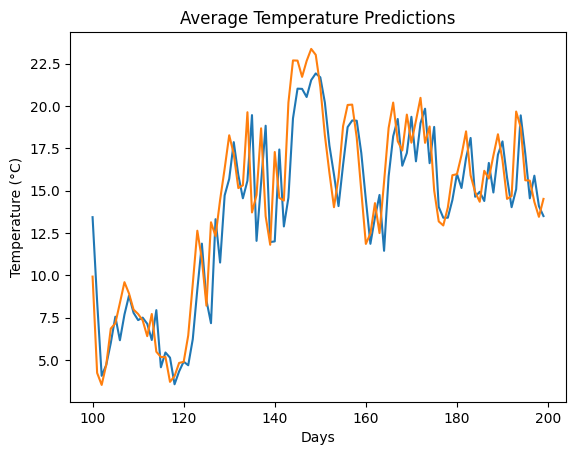

In [27]:
plt.title('Average Temperature Predictions')
plt.xlabel('Days')
plt.ylabel('Temperature (°C)')
plt.plot(train_results['Train Predictions'][100:200])
plt.plot(train_results['Actuals'][100:200])

In [28]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test.flatten()})
test_results

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


,Test Predictions,Actuals
0,5.305233,5.45
1,4.554824,5.39
2,5.085983,3.42
3,2.991233,2.62
4,2.824378,1.44
...,...,...
3081,14.737942,17.60
3082,17.980894,20.59
3083,20.117680,22.37
3084,21.038401,23.97


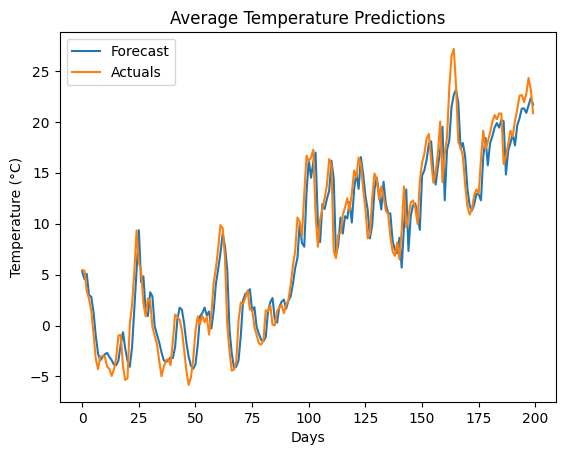

In [29]:
plt.title('Average Temperature Predictions')
plt.xlabel('Days')
plt.ylabel('Temperature (°C)')
plt.plot(test_results['Test Predictions'][:200], label= "Forecast")
plt.plot(test_results['Actuals'][:200], label= "Actuals")
plt.legend()


Mean Squared Error (MSE): 4.7679477351495665


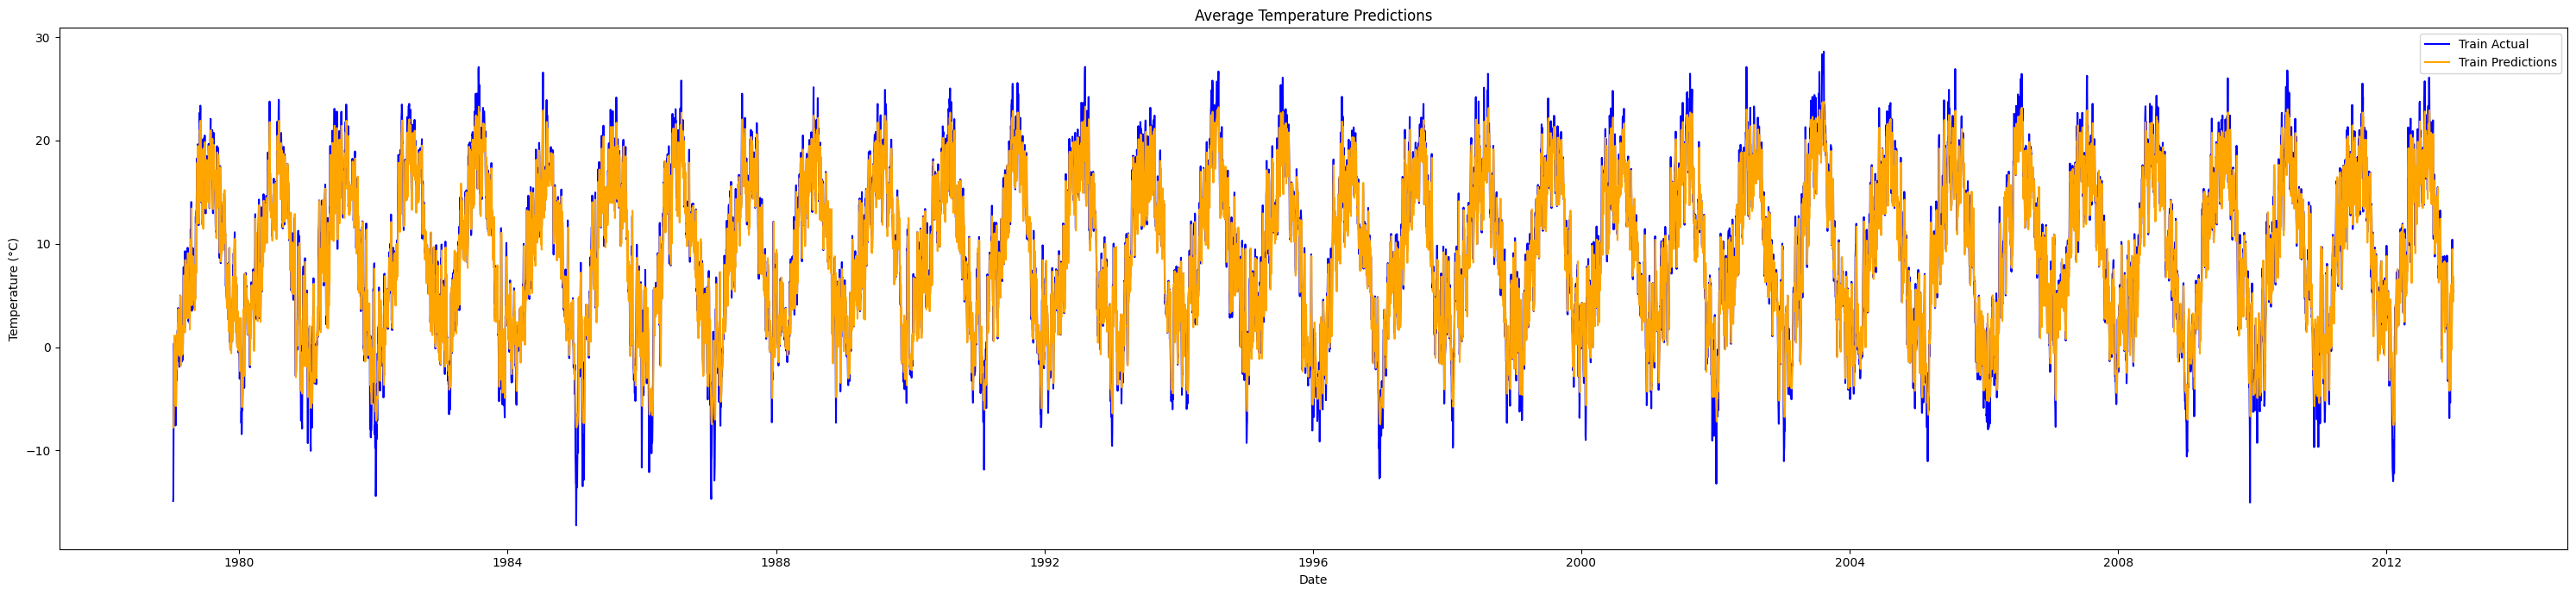

In [30]:
# Plot training data
plt.figure(figsize=(30, 7))
# Adding title and labels
plt.title('Average Temperature Predictions')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.tight_layout()
plt.plot(train_df.index[window_size:], y_train, label='Train Actual', color='blue')
plt.plot(train_df.index[window_size:], train_predictions, label='Train Predictions', color='orange')
plt.legend()
# Compute Mean Squared Error (MSE) between actual and forecasted daily data
mse = mean_squared_error(y_train, train_predictions)
print("Mean Squared Error (MSE):", mse)


Mean Squared Error (MSE): 4.592814595355876


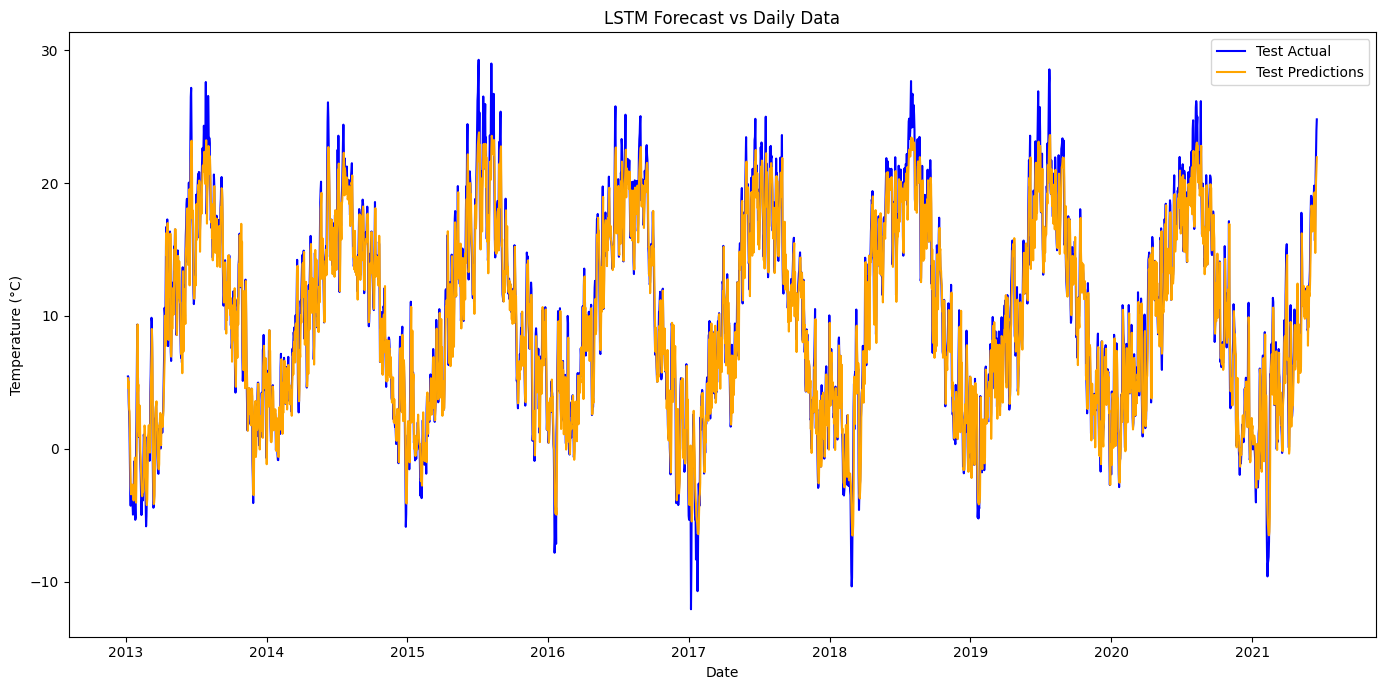

In [31]:
# Plot training data
plt.figure(figsize=(14, 7))
# Adding title and labels
plt.title('LSTM Forecast vs Daily Data')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.tight_layout()
plt.plot(test_df.index[window_size:], y_test, label='Test Actual', color='blue')
plt.plot(test_df.index[window_size:], test_predictions, label='Test Predictions', color='orange')
plt.legend()
# Compute Mean Squared Error (MSE) between actual and forecasted daily data
mse = mean_squared_error(y_test, test_predictions)
print("Mean Squared Error (MSE):", mse)

## Time Series Prediction using LLag LLama
Now, we repeat the same process with using Llag Llama Model

In [32]:
cd lag-llama

c:\Users\AliAlpOezer\Desktop\Time_Series_Forecasting_Papers_and_relevant_files\Time-Series-Analysis\lag-llama


In [34]:
from itertools import islice

import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd
from gluonts.dataset.common import ListDataset

from lag_llama.gluon.estimator import LagLlamaEstimator
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from lag_llama.gluon.estimator import LagLlamaEstimator

from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

OSError: [WinError 126] Das angegebene Modul wurde nicht gefunden. Error loading "c:\Python311\Lib\site-packages\torch\lib\shm.dll" or one of its dependencies.

### Load the checkpoint and initialize the model

In [ ]:
%%time

# Define the prediction length and frequency
prediction_length = len(test_series_monthly)
freq = 'M'
ckpt_path = '/content/new-lag-llama/lag-llama.ckpt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt = torch.load(ckpt_path,  map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
estimator = LagLlamaEstimator(
    ckpt_path=ckpt_path,
    prediction_length=prediction_length,
    context_length=32,
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    scaling=estimator_args["scaling"],
    time_feat=estimator_args["time_feat"],
    rope_scaling=None,
    batch_size=32,
    num_parallel_samples=100,
    device=device
)

CPU times: total: 46.9 ms
Wall time: 110 ms


### Create the transformation and predictor

In [ ]:
transformation = estimator.create_transformation()
lightning_module = estimator.create_lightning_module()
predictor = estimator.create_predictor(transformation, lightning_module)

### Make predictions on the test data using make_evaluation_predictions

In [ ]:
%%time
forecast_it, ts_it = make_evaluation_predictions(
    dataset=whole_data,
    predictor=predictor,
    #num_samples=100
)

forecasts = list(forecast_it)
tss = list(ts_it)


CPU times: total: 8min 17s
Wall time: 3min 25s


In [ ]:
predicted_values = [forecast.samples.mean() for forecast in forecasts]

In [ ]:
samples = forecasts[0].samples
all_elements = samples.flatten()
len(samples[0])
# Initialize lists to store mean, min, and max for each time step
means = []
mins = []
maxs = []

# Loop over each time step (assuming each sample has the same length)
for i in range(samples.shape[1]):
    time_step_samples = samples[:, i]
    means.append(np.mean(time_step_samples))
    mins.append(np.min(time_step_samples))
    maxs.append(np.max(time_step_samples))

### Results And Metrics For Monthly Average Comparasion
  Obtain some metrics for our reference. The CRPS metric is a commonly used metric in time series forecasting literature. We obtain a CRPS of 0.2531 with this dataset (close to the number reported in Table 1 of the paper [Lag-Llama: Towards Foundation Models for Probabilistic Time Series Forecasting](https://arxiv.org/abs/2302.06584)).

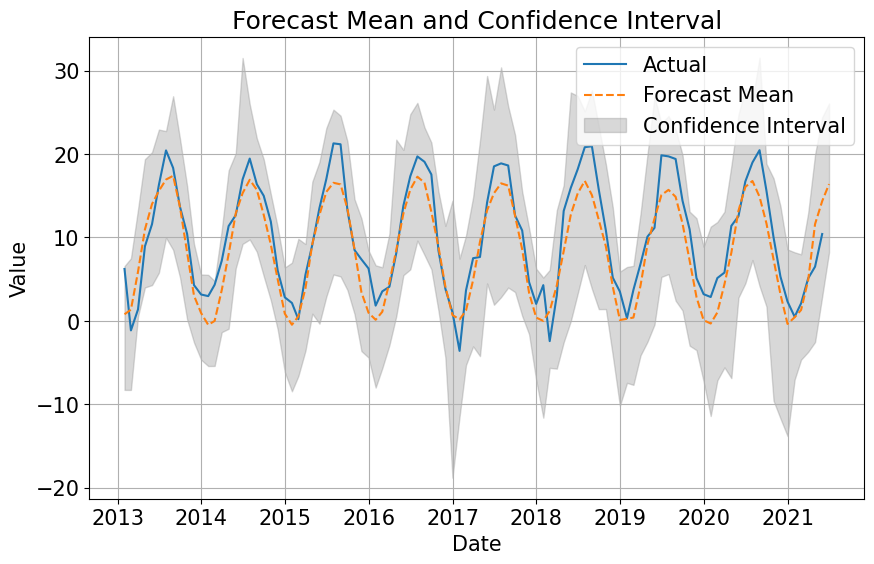

Mean Squared Error (MSE): 7.971479993577227


Running evaluation: 1it [00:00,  7.56it/s]


CRPS: 0.17252789746732816


In [ ]:

# Assuming the forecast starts from '2013-01' and has a monthly frequency
start_date = pd.Period('2013-01', freq='M')
dates = pd.date_range(start=start_date.start_time, periods=len(means), freq='M')

# Convert to pandas Series for easier plotting
means_series = pd.Series(means, index=dates)
mins_series = pd.Series(mins, index=dates)
maxs_series = pd.Series(maxs, index=dates)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(test_series_monthly.index, test_series_monthly.values, label="Actual")
plt.plot(dates, means_series, label="Forecast Mean", linestyle="--")
plt.fill_between(dates, mins_series, maxs_series, color='gray', alpha=0.3, label="Confidence Interval")

# Labels and title
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Llag Lama Forecast vs Monthly Average Tempature With Confidence Interval")
plt.legend()
plt.grid(True)

# Show plot
plt.show()
# Compute Mean Squared Error (MSE) between actual and forecasted daily data
mse_overall = mean_squared_error(test_series_monthly, means_series[:101])
print("Mean Squared Error (MSE):", mse_overall)
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))
print("CRPS:", agg_metrics['mean_wQuantileLoss'])


### Results And Metrics For Daily Average Comparasion With The Real Data


Mean Squared Error (MSE): 24.84679066135063


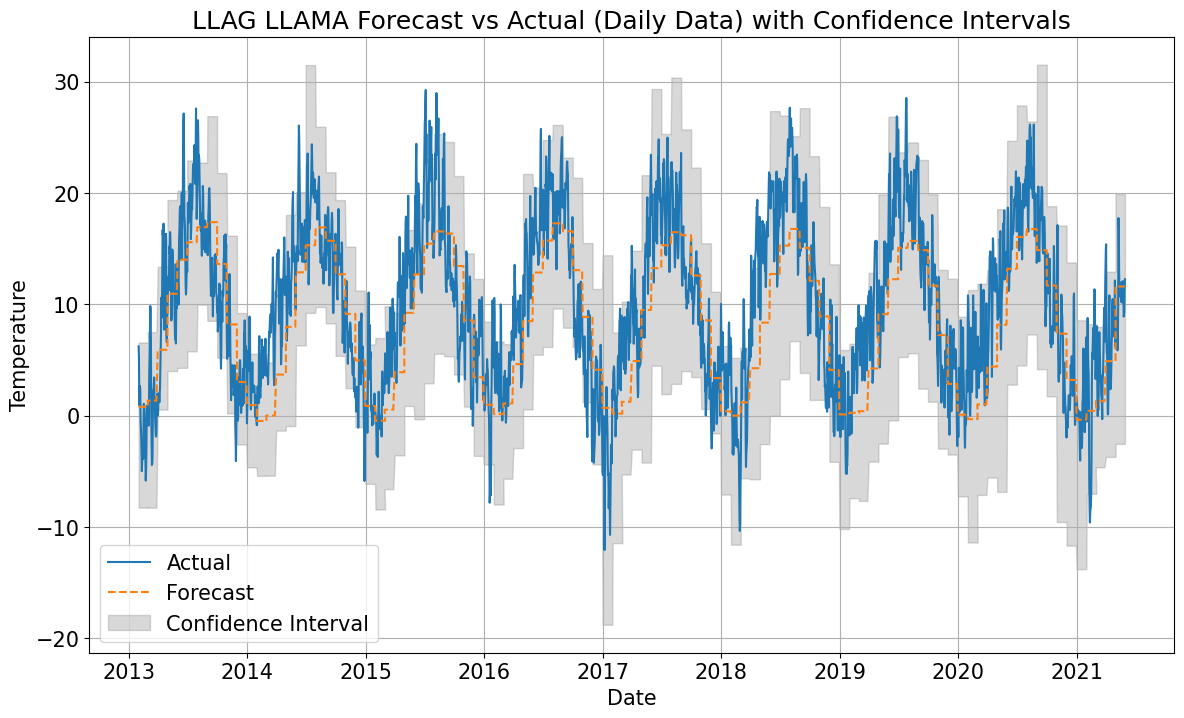

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Assuming the forecast starts from '2013-01' and has a monthly frequency
start_date = pd.Period('2013-01', freq='M')
dates = pd.date_range(start=start_date.start_time, periods=len(means), freq='M')

# Convert to pandas Series for easier plotting
means_series = pd.Series(means, index=dates)
mins_series = pd.Series(mins, index=dates)
maxs_series = pd.Series(maxs, index=dates)

# Disaggregate the monthly forecast to daily data
forecast_daily_llag_llama = []
conf_int_low_daily_llag_llama = []
conf_int_high_daily_llag_llama = []

for month, mean, (conf_low, conf_high) in zip(means_series.index, means_series.values, zip(mins_series.values, maxs_series.values)):
    days_in_month = month.days_in_month
    daily_forecast = np.full(days_in_month, mean)
    daily_conf_low = np.full(days_in_month, conf_low)
    daily_conf_high = np.full(days_in_month, conf_high)
    
    forecast_daily_llag_llama.append(pd.Series(daily_forecast, index=pd.date_range(month, periods=days_in_month)))
    conf_int_low_daily_llag_llama.append(pd.Series(daily_conf_low, index=pd.date_range(month, periods=days_in_month)))
    conf_int_high_daily_llag_llama.append(pd.Series(daily_conf_high, index=pd.date_range(month, periods=days_in_month)))

forecast_daily_llag_llama = pd.concat(forecast_daily_llag_llama)
conf_int_low_daily_llag_llama = pd.concat(conf_int_low_daily_llag_llama)
conf_int_high_daily_llag_llama = pd.concat(conf_int_high_daily_llag_llama)

# Adjust the forecast_daily start date to match test_df's start date
start_date = test_df.index[0]
end_date = test_df.index[-1]
forecast_daily_llag_llama = forecast_daily_llag_llama.loc[start_date:end_date]
conf_int_low_daily_llag_llama = conf_int_low_daily_llag_llama.loc[start_date:end_date]
conf_int_high_daily_llag_llama = conf_int_high_daily_llag_llama.loc[start_date:end_date]

# Reindex test_df to ensure it covers the same date range as forecast_daily
test_daily_llag_llama = test_df['temp_avg'].reindex(pd.date_range(start_date, end_date, freq='D'))

# Compute Mean Squared Error (MSE) between actual and forecasted daily data
mse_llag_llama = mean_squared_error(test_daily_llag_llama, forecast_daily_llag_llama[:3041])
print("Mean Squared Error (MSE):", mse_llag_llama)

# Plot the forecasts against the actual values along with confidence intervals
plt.figure(figsize=(14, 8))
plt.plot(test_daily_llag_llama.index, test_daily_llag_llama.values, label="Actual")
plt.plot(forecast_daily_llag_llama.index, forecast_daily_llag_llama.values, label="Forecast", linestyle="--")
plt.fill_between(forecast_daily_llag_llama.index, conf_int_low_daily_llag_llama.values, conf_int_high_daily_llag_llama.values, color='gray', alpha=0.3, label="Confidence Interval")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("LLAG LLAMA Forecast vs Daily Data with Confidence Intervals")
plt.legend()
plt.grid(True)
plt.show()


### Results And Metrics For Comparasion With The Real Data


In [ ]:
forecast_daily.min()

## Time Series Prediction using Prophet


In [ ]:
from prophet import Prophet

In [ ]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320) % 1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(weather_wue_df, label='temp_avg')
features_and_target = pd.concat([X, y], axis=1)


In [ ]:
%%time

# Format data for prophet model using ds and y
train_prophet = train_df.reset_index() \
    .rename(columns={'date':'ds',
                     'temp_avg':'y'})
train_prophet

CPU times: total: 0 ns
Wall time: 8.63 ms


,ds,temp_max,temp_min,y,rain,snow,weather_desc
0,1979-01-01,-8.23,-17.83,-14.54,0.00,0.10,"light snow,snow,broken clouds,few clouds"
1,1979-01-02,-9.08,-14.35,-11.86,0.00,0.35,"light snow,overcast clouds,mist,haze,broken cl..."
2,1979-01-03,-6.65,-13.16,-9.72,0.00,0.00,"broken clouds,mist,overcast clouds,scattered c..."
3,1979-01-04,-9.84,-17.65,-13.18,0.00,0.00,"sky is clear,mist,scattered clouds"
4,1979-01-05,-12.06,-18.39,-15.56,0.00,0.00,"mist,broken clouds,fog"
...,...,...,...,...,...,...,...
12414,2012-12-27,7.14,5.03,6.39,7.52,0.00,"few clouds,broken clouds,scattered clouds,over..."
12415,2012-12-28,5.42,3.20,4.53,3.27,0.00,"overcast clouds,light rain,scattered clouds,mo..."
12416,2012-12-29,8.44,5.08,6.09,0.00,0.00,"overcast clouds,broken clouds,sky is clear,sca..."
12417,2012-12-30,7.69,5.25,6.43,0.00,0.00,"overcast clouds,scattered clouds,broken clouds..."


### Instanciating the Prophet Model and Training

In [ ]:
%%time
model = Prophet()
model.fit(train_prophet)

17:18:47 - cmdstanpy - INFO - Chain [1] start processing
17:18:50 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 719 ms
Wall time: 6.67 s


### Prediction Prophet 

In [ ]:
# Predict on test set with model
test_prophet = test_df['temp_avg'].reset_index() \
    .rename(columns={'date':'ds',
                     'temp_avg':'y'})

ptest_fcst = model.predict(test_prophet)

### Results

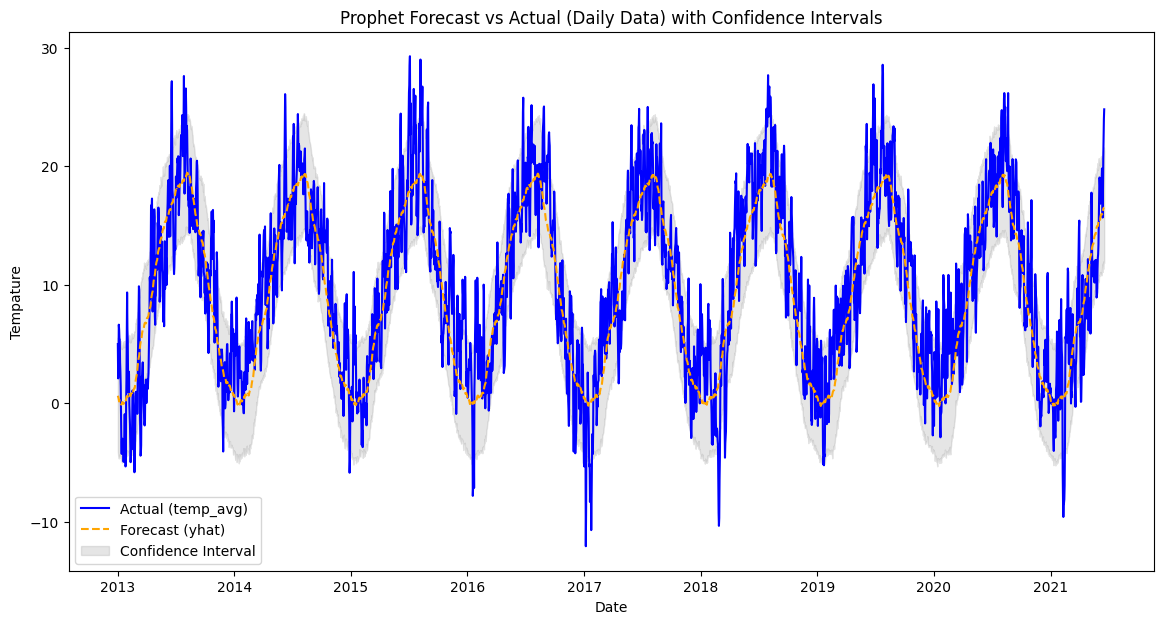

Mean Squared Error (MSE): 13.873672875287399


In [ ]:

# Plotting
plt.figure(figsize=(14, 7))
# Plot actual data
plt.plot(test_df.index, test_df['temp_avg'],color="blue", label='Actual (temp_avg)')
# Plot forecast
plt.plot(ptest_fcst['ds'], ptest_fcst['yhat'], label='Forecast (yhat)',color="orange", linestyle="--")

# Plot confidence interval
plt.fill_between(ptest_fcst['ds'], ptest_fcst['yhat_lower'], ptest_fcst['yhat_upper'], color='grey', alpha=0.2, label='Confidence Interval')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Tempature')
plt.title('Prophet Forecast vs Actual (Daily Data) with Confidence Intervals')
plt.legend()
# Show plot
plt.show()

# Calculate Mean Squared Error
mse = mean_squared_error(test_df["temp_avg"], ptest_fcst["yhat"])
print("Mean Squared Error (MSE):", mse)


c:\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].d

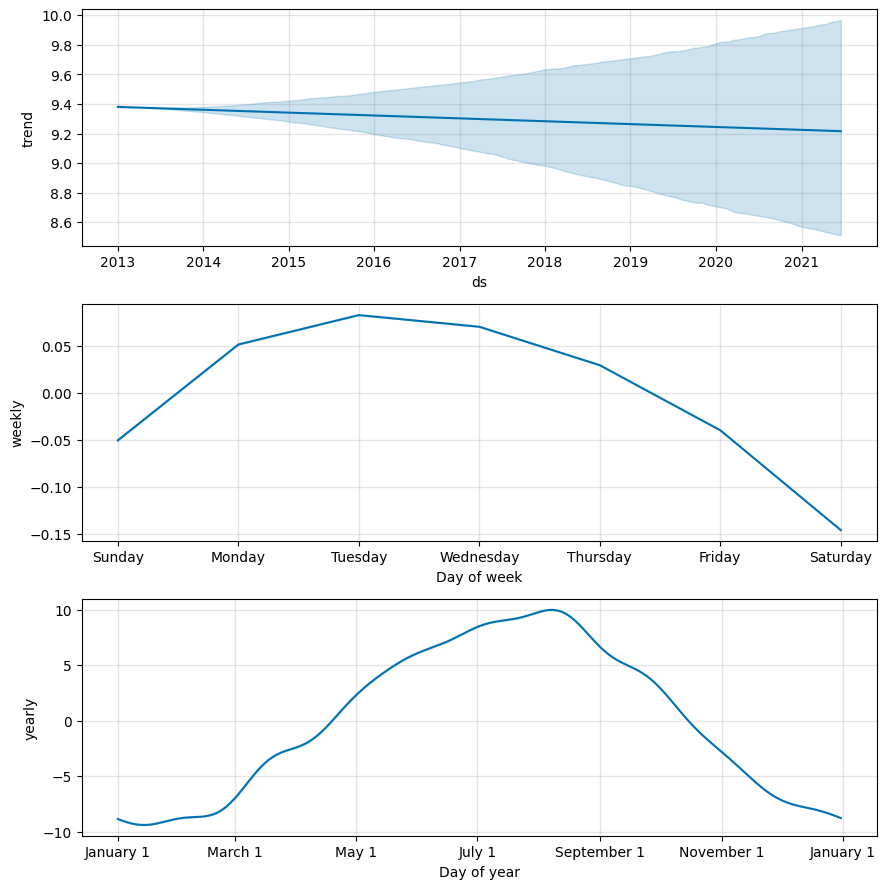

In [ ]:
fig = model.plot_components(ptest_fcst)

c:\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


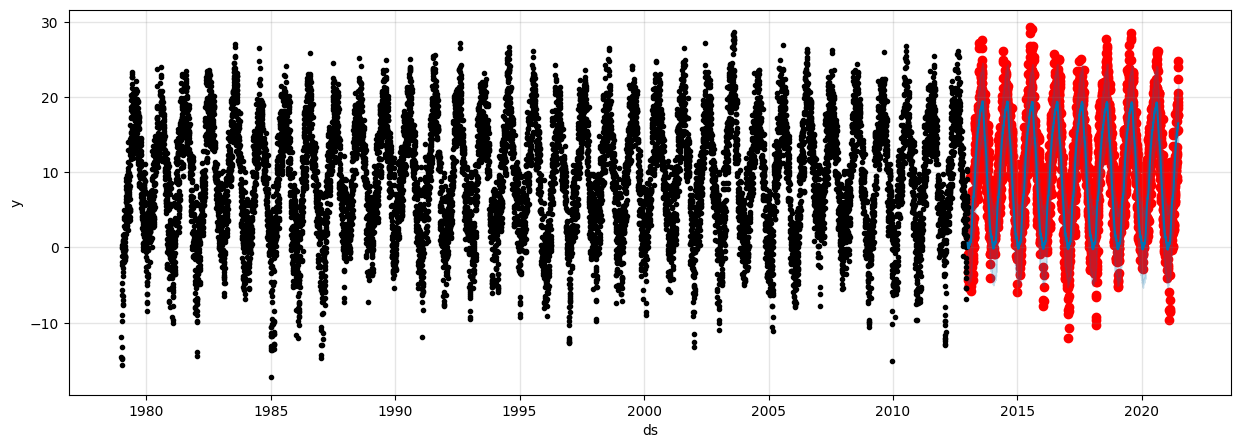

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test_df['temp_avg'].index, test_df['temp_avg'], color='r')
fig = model.plot(ptest_fcst, ax=ax)

ConversionError: Failed to convert value(s) to axis units: '01-01-2015'

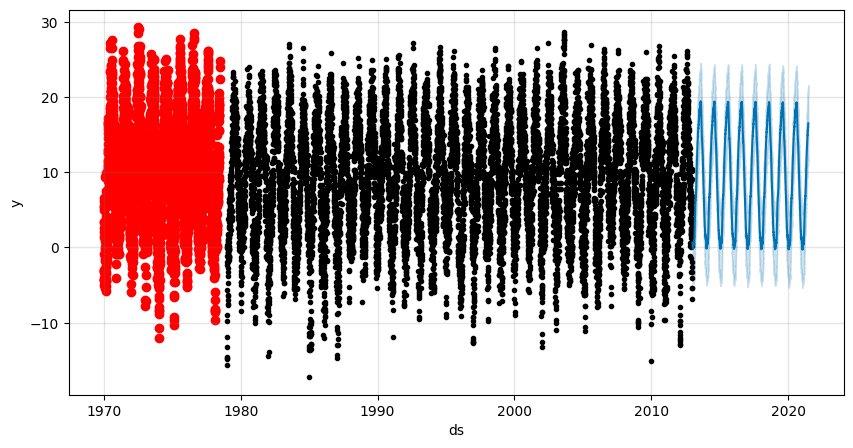

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(ptest_fcst.index, test_df['temp_avg'], color='r')
fig = model.plot(ptest_fcst, ax=ax)
ax.set_xbound(lower='01-01-2015',
              upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

In [ ]:
ptest_fcst

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,9.381051,-4.253861,5.383445,9.381051,9.381051,-8.755768,-8.755768,-8.755768,0.083357,0.083357,0.083357,-8.839125,-8.839125,-8.839125,0.0,0.0,0.0,0.625283
1,2013-01-02,9.380998,-4.221599,5.166243,9.380998,9.380998,-8.835911,-8.835911,-8.835911,0.070909,0.070909,0.070909,-8.906820,-8.906820,-8.906820,0.0,0.0,0.0,0.545087
2,2013-01-03,9.380945,-4.380892,4.936246,9.380945,9.380945,-8.942635,-8.942635,-8.942635,0.029860,0.029860,0.029860,-8.972495,-8.972495,-8.972495,0.0,0.0,0.0,0.438311
3,2013-01-04,9.380892,-4.332131,5.270743,9.380892,9.380892,-9.075010,-9.075010,-9.075010,-0.039599,-0.039599,-0.039599,-9.035411,-9.035411,-9.035411,0.0,0.0,0.0,0.305882
4,2013-01-05,9.380839,-4.526791,4.871175,9.380839,9.380839,-9.241003,-9.241003,-9.241003,-0.146160,-0.146160,-0.146160,-9.094843,-9.094843,-9.094843,0.0,0.0,0.0,0.139836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3086,2021-06-14,9.217063,11.425428,20.880584,8.468654,9.977758,7.055213,7.055213,7.055213,0.051949,0.051949,0.051949,7.003264,7.003264,7.003264,0.0,0.0,0.0,16.272276
3087,2021-06-15,9.217009,11.459429,21.379819,8.467701,9.978063,7.162602,7.162602,7.162602,0.083357,0.083357,0.083357,7.079245,7.079245,7.079245,0.0,0.0,0.0,16.379611
3088,2021-06-16,9.216956,11.816327,21.350069,8.466749,9.978368,7.228703,7.228703,7.228703,0.070909,0.070909,0.070909,7.157794,7.157794,7.157794,0.0,0.0,0.0,16.445659
3089,2021-06-17,9.216903,11.852354,21.399769,8.465796,9.978673,7.268790,7.268790,7.268790,0.029860,0.029860,0.029860,7.238930,7.238930,7.238930,0.0,0.0,0.0,16.485693
